# tSNE of dengue infected Huh7 cells by gene expression - eLife style

In [4]:
# Modules
import os
import sys
import pickle
import argparse
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['SINGLET_CONFIG_FILENAME'] = 'singlet.yml'
sys.path.append('/home/fabio/university/postdoc/singlet')
from singlet.dataset import Dataset

### Load the data, normalize, add virus info, calculate correlations, etc. etc.

In [3]:
ds = Dataset(
        counts_table='dengue',
        samplesheet='dengue',
        featuresheet='humanGC38',
        )
ds.query_samples_by_counts('total >= 50000', inplace=True)

ds.samplesheet.rename(columns={'time [h]': 'time'}, inplace=True)
cov = ds.samplesheet['coverage'] = ds.counts.sum(axis=0)
ds.counts.normalize('counts_per_million', inplace=True)
ds.samplesheet['virus_reads_per_million'] = 0
for virus in ('dengue', 'zika'):
    ind = ds.samplesheet['virus'] == virus
    n = ds.samplesheet.loc[ind, 'number'+virus.capitalize()+'Reads'].astype(int)
    ds.samplesheet.loc[ind, 'virus_reads_per_million'] = 1e6 * n / (cov.loc[ind] + n)
ds.counts.log(inplace=True)

# Select only some cells for comparison
dsc = ds.copy()
dsc.samplesheet = dsc.samplesheet.query('500 < virus_reads_per_million')

# Get correlations
dsv = dsc.split(phenotypes='virus')
vs = []
cos = []
for virus, dsvi in dsv.items():
    co = dsvi.correlation.correlate_features_phenotypes(
            phenotypes='virus_reads_per_million',
            fillna=0).fillna(0)
    cos.append(co)
    vs.append(virus)
cos = pd.concat(cos, axis=1)
cos.columns = pd.Index(vs, name='virus')

### Add info on dengue genomics
This data comes from Felix

In [5]:
fn_felix = '../data/metadataD_SNV.pkl'
with open(fn_felix, 'rb') as ff:
    meta_felix = pickle.load(ff).set_index('name')

In [13]:
newcols = set(meta_felix.columns) - set(ds.samplesheet.columns) - set(['qPCR', 'time [h]', 'ID'])
for col in newcols:
    ds.samplesheet[col] = meta_felix.loc[ds.samplesheet.index, col]

### Plot tSNE
Here all cells in the dengue experiment are kept for now, including uninfected controls and bystanders.

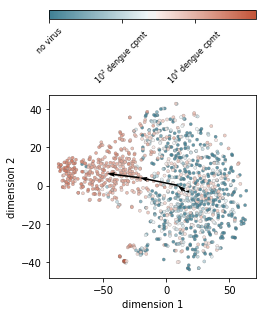

In [15]:
# Plot dimensionality reductions for all genes at the ourskirts of the correlation plot
dsd = ds.copy()
features = cos.index[np.abs(cos).max(axis=1) >= 0.4]
dsd.counts = dsd.counts.loc[features]
dsd.samplesheet['virus_log'] = np.log10(1 + dsd.samplesheet['virus_reads_per_million'])
# t-SNE is not deterministic, so save to file to make sure we can reproduce
# the paper figures with variations if needed
vs_fn = '../data/tsne_coordinates.tsv'
if os.path.isfile(vs_fn):
    vs = pd.read_csv(vs_fn, sep='\t', index_col=0)
else:
    vs = dsd.dimensionality.tsne(perplexity=10)
    vs.to_csv(vs_fn, sep='\t')
cmap = sns.diverging_palette(220, 20, as_cmap=True, center='light')
fig, axs = plt.subplots(
        nrows=2, ncols=1, figsize=(3.8, 4.5),
        gridspec_kw={'height_ratios': [1, 20]})
axs = axs[::-1]
dsd.plot.scatter_reduced_samples(
        vs,
        color_by='virus_log',
        cmap=cmap,
        alpha=0.8,
        ax=axs[0],
        s=10,
        lw=.25,
        edgecolor=[0.4, 0.4, 0.4],
        zorder=10)
norm1 = mpl.colors.Normalize(
        vmin=dsd.samplesheet['virus_log'].values.min(),
        vmax=dsd.samplesheet['virus_log'].values.max())
cb1 = mpl.colorbar.ColorbarBase(
        ax=axs[1], cmap=cmap, norm=norm1, orientation='horizontal')
cb1.set_ticks([-4, -2, 0, 2, 4])
cb1.set_ticklabels(
        ['$10^4$ Zika cpmt', '$10^2$ Zika cpmt', 'no virus',
         '$10^2$ dengue cpmt', '$10^4$ dengue cpmt'])
for tkl in cb1.ax.get_xticklabels():
    tkl.set_rotation(45)
    tkl.set_fontsize(8)
axs[0].grid(False)

# Plot mean of samples at increasing viral load
bins = [0, 30, 200, 1000, 10000, 70000, 500000]
for virus in ['dengue', 'zika']:
    ph = dsd.samplesheet['virus_reads_per_million']
    vi = dsd.samplesheet['virus']
    vms = pd.concat([vs.loc[
        (ph >= bins[i]) & (ph < bins[i+2]) & (vi == virus)
        ].mean(axis=0) for i in range(len(bins) - 2)],
        axis=1).T
    x = vms.values[:, 0]
    y = vms.values[:, 1]
    axs[0].quiver(
            x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
            scale_units='xy', angles='xy', scale=1,
            zorder=20)

plt.tight_layout(h_pad=0.5, w_pad=0.1)